# This notebook will do the following:

* Queries metadata for all Chandra observations using HEASARC VO services.

* Extracts their sky coordinates.

* Plots them on an all-sky map using matplotlib Aitoff projection.

* Queries all sources along the Galactic plane from the Chandra Source Catalog and the Fermi Source Catalog

* Performs a simple cross-match of the sources, saved to a new table

* Assesses the properties of the new sample of sources that have a CXC and Fermi counterpart

# Dependencies

* astropy
* pyvo
* matplotlib
* healpy
* os
* astroquery
* numpy

## Step 1: Imports

In [1]:
import pyvo as vo
import healpy
import os
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.heasarc import Heasarc
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import numpy as np
from astropy.table import unique, vstack
from astropy.wcs import WCS
%matplotlib inline
plt.style.use(astropy_mpl_style)

## Step 2: Use HEASARC VO Service to access Chandra observation metdata

In [2]:
heasarc = vo.dal.TAPService("https://heasarc.gsfc.nasa.gov/xamin/vo/tap")

## Step 3: Run a ADQL query to get all observation positions

In [3]:
query = """
SELECT TOP 99999999 obsid, ra, dec, exposure, detector, time, name
FROM chanmaster
WHERE ra IS NOT NULL AND dec IS NOT NULL
"""


results = heasarc.search(query)
table = results.to_table()
table[:5]

obsid,ra,dec,exposure,detector,time,name
,deg,deg,s,,d,
int32,float64,float64,float64,object,float64,object
21421,91.42333,-86.63194,23060,ACIS-S,58532.4990856481,ESO005-G004
10143,302.30417,-85.64633,2030,ACIS-S,54810.445474537,1RXSJ200924.1-853911
22326,49.31604,-85.54043,37930,ACIS-I,59201.2466550926,RE J0317-853
15124,354.93333,-85.17583,23080,ACIS-I,56636.0022569444,ACO 4023
3477,242.76000,-83.70000,20060,ACIS-S,52364.0807638889,GRB020321


## Step 4: Define the coordinates using SkyCoord

In [4]:
coords = SkyCoord(ra=table['ra'],
                  dec=table['dec'])

## Step 5: Plot an all-sky map in Aitoff projection

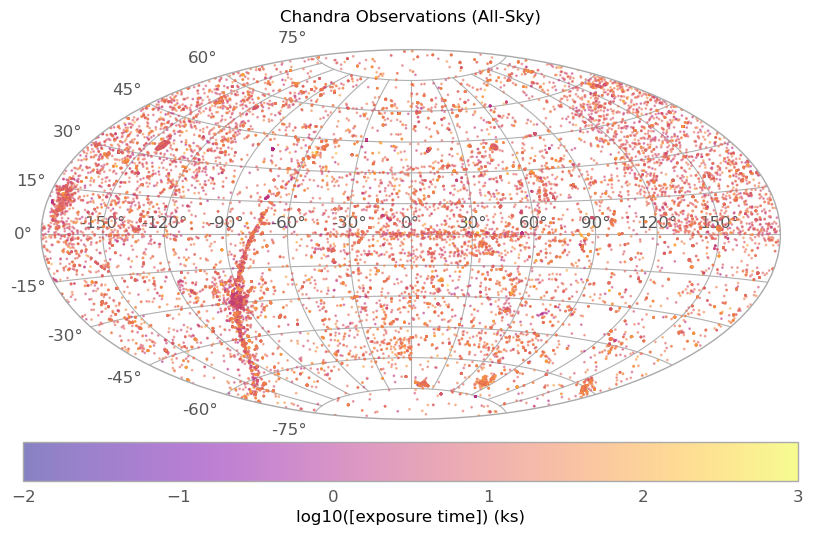

In [5]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="aitoff")

mask = table['exposure'] != 0
exp_log = np.log10(table['exposure'][mask]/1000)

# Convert to radians and flip for Aitoff
ra_rad = coords.ra.wrap_at(180*u.deg).radian[mask]
dec_rad = coords.dec.radian[mask]

sc = ax.scatter(ra_rad, dec_rad, c=exp_log,s=1, alpha=0.5, cmap='plasma')
cb = plt.colorbar(sc, orientation='horizontal', pad=0.05)
cb.set_label("log10([exposure time]) (ks)",fontsize=12)
ax.grid(True)
plt.title("Chandra Observations (All-Sky)",fontsize=12,pad=20)
plt.show()

# Step 6: Find Chandra source locations and fluxes for all-sky using the CSC

## Find those that lie along the Galactic plane and plot the sky map.

In [6]:
columns = Heasarc.list_columns(catalog_name='csc')
columns.pprint(align='<',max_width=-1, max_lines=-1)

    name                                       description                                      unit   
------------ ------------------------------------------------------------------------------- ----------
significance Highest Source Signal-to-Noise Ratio Across All Stacked Obs. and Energy Bands             
b_flux_ap_hi Net Energy Flux from Source Region Aperture (68% Upper Limit); ACIS Broad Band  erg/s/cm^2
m_flux_ap    Net Energy Flux from Source Region Aperture, Bayesian Analysis; ACIS Medium     erg/s/cm^2
m_flux_ap_hi Net Energy Flux from Source Region Aperture (68% Upper Limit); ACIS Medium Band erg/s/cm^2
dec          Declination                                                                     degree    
b_flux_ap_lo Net Energy Flux from Source Region Aperture (68% Lower Limit); ACIS Broad Band  erg/s/cm^2
m_flux_ap_lo Net Energy Flux from Source Region Aperture (68% Lower Limit); ACIS Medium Band erg/s/cm^2
b_flux_ap    Net Energy Flux from Source Region Aperture, Bayesi

In [7]:
# get a comma-separated list of the default columns in csc. Use columns = '*', to get all columns
columns = ', '.join(Heasarc._get_default_columns('csc'))
# construct a query for all entries; use TOP with a large number greater than the server's 1e5 LIMIT
query = f'SELECT TOP 9999999 {columns} FROM csc'
sample = Heasarc.query_tap(query).to_table()

In [8]:
print(sample)

         name            ra       dec     ... m_flux_ap_hi m_flux_ap_lo
                        deg       deg     ...  erg/s/cm^2   erg/s/cm^2 
--------------------- -------- ---------- ... ------------ ------------
2CXO J000054.0+672120 0.225197  67.355576 ...        3e-15      1.4e-15
2CXO J000054.0-245948 0.225266 -24.996999 ...      5.7e-16      1.2e-16
2CXO J000054.1-575151 0.225963 -57.864391 ...      4.7e-16        2e-16
2CXO J000054.4+321418 0.226864  32.238517 ...      5.1e-15      2.3e-15
2CXO J000054.8-500935 0.228498 -50.159933 ...        2e-15      1.2e-15
2CXO J000054.8-573852 0.229198 -57.648115 ...      1.1e-14      7.8e-15
                  ...      ...        ... ...          ...          ...
2CXO J000053.2-544052 0.221914 -54.681216 ...           --           --
2CXO J000053.4-575208 0.222548 -57.868943 ...      7.7e-16        4e-16
2CXO J000053.5+171337 0.223237  17.227042 ...      6.5e-15      1.7e-15
2CXO J000053.5+672614 0.223249  67.437327 ...      4.2e-15      

There are a total of 407806 sources in the CSC. Now let's grab the relevant properties we need.

In [9]:
query = """
SELECT TOP 9999999 name, ra, dec, b_flux_ap
FROM csc
WHERE b_flux_ap > 0
"""

sample = heasarc.search(query)
sample_table = sample.to_table()
sample_table[:5]

name,ra,dec,b_flux_ap
,deg,deg,erg/s/cm^2
object,float64,float64,float64
2CXO J000054.0+672120,0.225197,67.355576,2.7e-14
2CXO J000054.0-245948,0.225266,-24.996999,7.8e-15
2CXO J000054.1-575151,0.225963,-57.864391,7.2e-15
2CXO J000054.8-500935,0.228498,-50.159933,4.2e-15
2CXO J000054.8-573852,0.229198,-57.648115,4.6e-14


In [10]:
print(len(sample_table))
print(f"{sample_table['b_flux_ap'].min():.2e}")
print(sample_table['b_flux_ap'].max())
print(np.sum(sample_table['b_flux_ap'])/len(sample_table))

343779
1.33e-18
1.3178257194102e-09
6.578420406143907e-14


We can check the sample properties in the cell above to make sure we are getting the same output each time. See also [GitHub issue #3387 in Astroquery](https://github.com/astropy/astroquery/issues/3387).

In principle, one could try:

``sample = heasarc.query_region(
SkyCoord(0, 0, unit='deg',frame='galactic'),
spatial='all-sky',
catalog='csc',
maxrec=None
)``

Once the following bugs are resolved:
* fields parameter errors out every time.
* maxrec messes with the query, sending a random sample that matches the criteria for a maximum of 1e5 sources. 

Next we mask sources that meet the Galactic plane criteria: $|b|< 10\,^\circ$.

In [11]:
# Create SkyCoord from the sample table
coords = SkyCoord(ra=sample_table['ra'], dec=sample_table['dec'], unit='deg')
gal_coords = coords.galactic

# Apply Galactic latitude filter: |b| <= 10°
mask = np.abs(gal_coords.b.deg) <= 10

# Filter coordinates and data
filtered_coords = gal_coords[mask]
filtered_flux = sample_table['b_flux_ap'][mask]
filtered_names = sample_table['name'][mask]

print(f"Total sources in catalog: {len(coords)}")
print(f"Number of filtered sources: {len(filtered_coords)}")

Total sources in catalog: 343779
Number of filtered sources: 100896


Next, we will wrap the longitude coordinates for Aitoff projection. We did this above for Chandra observations, too.

In [12]:
print("Longitude range (unwrapped):", filtered_coords.l.min().deg, "to", filtered_coords.l.max().deg)
print("Longitude range (wrapped):", filtered_coords.l.wrap_at(180*u.deg).min().deg, "to", filtered_coords.l.wrap_at(180*u.deg).max().deg)

Longitude range (unwrapped): 7.268966595713397e-05 to 359.9999628317577
Longitude range (wrapped): -179.97416771920018 to 179.99153191582855


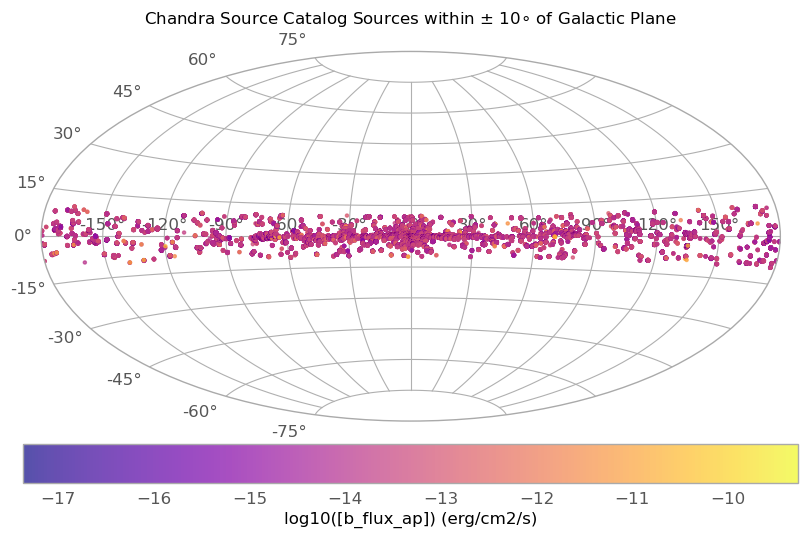

In [13]:
flux_log = np.log10(filtered_flux)

l_rad = filtered_coords.l.wrap_at(180*u.deg).radian
b_rad = filtered_coords.b.radian

plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='aitoff')

sc = ax.scatter(l_rad, b_rad, c=flux_log, cmap='plasma', s=5, alpha=0.7)
cb = plt.colorbar(sc, orientation='horizontal', pad=0.05)
cb.set_label("log10([b_flux_ap]) (erg/cm2/s)",fontsize=12)

ax.grid(True)
plt.title("Chandra Source Catalog Sources within $\pm$ 10$\circ$ of Galactic Plane",fontsize=12,pad=20)
plt.show()

We can plot a histogram of source count by longitude, too. Naturally the Galactic Center sees the largest number of sources. 

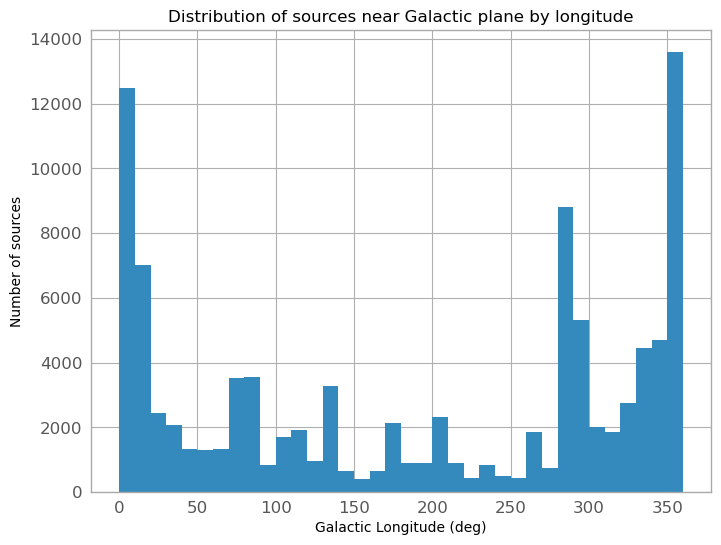

In [14]:
l_deg = filtered_coords.l.deg

plt.hist(l_deg, bins=36, range=(0, 360))
plt.xlabel('Galactic Longitude (deg)',fontsize=10)
plt.ylabel('Number of sources',fontsize=10)
plt.title('Distribution of sources near Galactic plane by longitude',fontsize=12)
plt.show()

The code below plots the sources along the Galactic plane again, but using the Astropy WCS package so we can display only the Galactic plane.

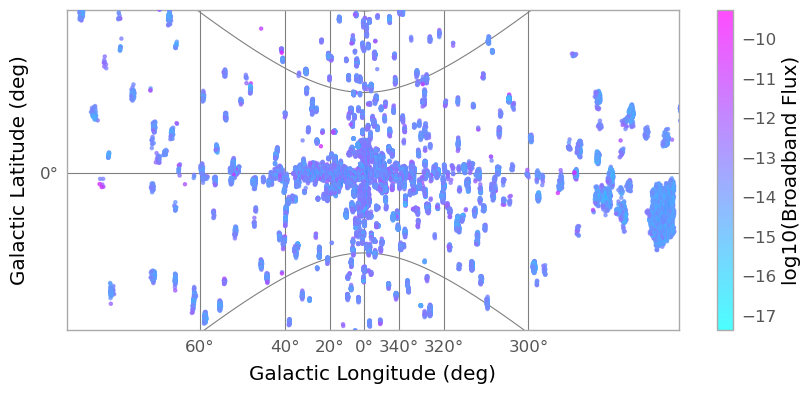

In [15]:
# 1. Build a WCS header manually for Galactic coordinates
wcs = WCS(naxis=2)
wcs.wcs.ctype = ['GLON-TAN', 'GLAT-TAN']  # Galactic longitude/latitude
wcs.wcs.crval = [0, 0]  # Center of the plot in l and b
wcs.wcs.crpix = [900, 50]  # Reference pixel
wcs.wcs.cdelt = [-0.2, 0.2]  # Degrees per pixel
wcs.wcs.cunit = ['deg', 'deg']

# 2. Prepare your data (Galactic longitudes/latitudes in degrees)
l_deg = filtered_coords.l.wrap_at(180 * u.deg).deg
b_deg = filtered_coords.b.deg
flux_log = np.log10(filtered_flux)

# 3. Convert world coords (deg) to pixel coords
x_pix, y_pix = wcs.wcs_world2pix(l_deg, b_deg, 0)

# 4. Plot
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(111, projection=wcs)

sc = ax.scatter(x_pix, y_pix, c=flux_log, cmap='cool', s=5, alpha=0.7)

cb = plt.colorbar(sc, orientation='vertical', pad=0.05)
cb.set_label('log10(Broadband Flux)')

# 5. Set axis limits in pixel coords to match lon/lat range
ax.set_xlim(0, 1850)  # 360 deg / 0.2 deg per pixel = 1800 pixels
ax.set_ylim(0, 100)   # 20 deg / 0.2 deg per pixel = 100 pixels

# 6. Axis labels, ticks, grid (in world coordinates)
ax.coords.grid(True, color='grey', ls='-')
ax.coords[0].set_axislabel('Galactic Longitude (deg)')
ax.coords[1].set_axislabel('Galactic Latitude (deg)')
ax.coords[0].set_ticks(spacing=20 * u.deg)
ax.coords[1].set_ticks(spacing=5 * u.deg)

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.15)
plt.show()

# Step 7: Read in the latest Fermi catalog

In [16]:
# Direct FSSC URL for 4FGL-DR4 catalog FITS file
fermi_url = "https://fermi.gsfc.nasa.gov/ssc/data/access/lat/14yr_catalog/gll_psc_v35.fit"
fermi_fname = "gll_psc_v35.fit"

if not os.path.exists(fermi_fname):
    print("Downloading 4FGL-DR4 catalog from FSSC...")
    os.system(f"curl -O {fermi_url}")
    print("Download complete.")

fermi_table = Table.read(fermi_fname)
print(f"Loaded {len(fermi_table)} Fermi sources.")

Loaded 7195 Fermi sources.


In [17]:
#Get Fermi column names
#fermi_table.colnames

# Step 8: Perform a cross-match between the Galactic plane CSC sample we created above and the Fermi catalog

In [18]:
csc = Table()
csc['csc_name'] = filtered_names
csc['csc_l'] = filtered_coords.l
csc['csc_b'] = filtered_coords.b
csc['b_flux_ap'] = filtered_flux

In [19]:
csc_coords = SkyCoord(l=csc['csc_l'], b=csc['csc_b'], unit='deg', frame='galactic')
fermi_coords = SkyCoord(l=fermi_table['GLON'], b=fermi_table['GLAT'], unit='deg', frame='galactic')

idx_fermi, idx_csc, sep2d, _ = csc_coords.search_around_sky(fermi_coords, 0.1 * u.deg)
#idx_fermi, idx_csc, sep2d, _ = fermi_coords.search_around_sky(csc_coords, 0.1 * u.deg)


Checking to see the cross-match indexed the results properly:

In [20]:
print(idx_csc)
print(idx_fermi)
print(sep2d.deg)

[    14     17     22 ... 100801 100802 100803]
[  11   11   11 ... 7175 7175 7175]
[0.0975211  0.09069425 0.07884114 ... 0.08540754 0.09512734 0.08858047]


In [21]:
print(csc[30]['csc_name'])
print(fermi_table[11]['Source_Name'])
print(sep2d[0].deg)

2CXO J000130.0+673052
4FGL J0002.1+6721c
0.09752110120189145


In [22]:
print(csc[33]['csc_name'])
print(fermi_table[11]['Source_Name'])
print(sep2d[1].deg)

2CXO J000134.0+672641
4FGL J0002.1+6721c
0.09069425271774767


Create new table of the matched sources and some of the properties we would like to retain. 

In [23]:
matched = Table()
matched['csc_name'] = csc['csc_name'][idx_csc]
matched['csc_l'] = csc['csc_l'][idx_csc]
matched['csc_b'] = csc['csc_b'][idx_csc]
matched['csc_flux'] = csc['b_flux_ap'][idx_csc]
matched['fermi_name'] = fermi_table['Source_Name'][idx_fermi]
matched['fermi_l'] = fermi_table['GLON'][idx_fermi]
matched['fermi_b'] = fermi_table['GLAT'][idx_fermi]
matched['fermi_r95'] = fermi_table['Conf_95_SemiMajor'][idx_fermi]
matched['fermi_flux'] = fermi_table['Energy_Flux100'][idx_fermi]
matched['fermi_class'] = fermi_table['CLASS1'][idx_fermi]
matched['sep_degree'] = sep2d.deg

print(f"Found {len(matched)} matches within 0.1°")
print(matched)

Found 19771 matches within 0.1°
       csc_name             csc_l        ... fermi_class      sep_degree    
                             deg         ...                                
--------------------- ------------------ ... ----------- -------------------
2CXO J000112.0+672314 118.11764827249455 ...       unk   0.09752110120189145
2CXO J000113.6+672107 118.11324333817218 ...       unk   0.09069425271774767
2CXO J000126.4+672339 118.14173989990837 ...       unk    0.0788411388603787
2CXO J000126.8+671848 118.12657916872396 ...       unk    0.0823245179517346
2CXO J000127.1+672353 118.14358886013505 ...       unk   0.07963004963143634
2CXO J000127.6+672220 118.13929934323465 ...       unk   0.06953347496188846
                  ...                ... ...         ...                 ...
2CXO J235836.2+623009 116.87599917133674 ...       spp    0.0881511101853717
2CXO J235831.6+623411 116.88096458316504 ...       spp   0.08252049833694755
2CXO J235833.3+622859 116.86655792082527 ...

There are 19,771 sources that have a CSC and Fermi counterpart within $0.1\,^\circ$. Note: This includes several of the same Fermi source overlapping with multiple CSC sources. We will filter this further below. 

## Plot a sky map of the matched table, plotting each source only once even if it appears more than once in the table just above. 

/Users/jeagle/miniforge3/envs/fermi/lib/python3.9/site-packages/numpy/lib/function_base.py:3639: RuntimeWarning: invalid value encountered in divide
  return sin(y)/y


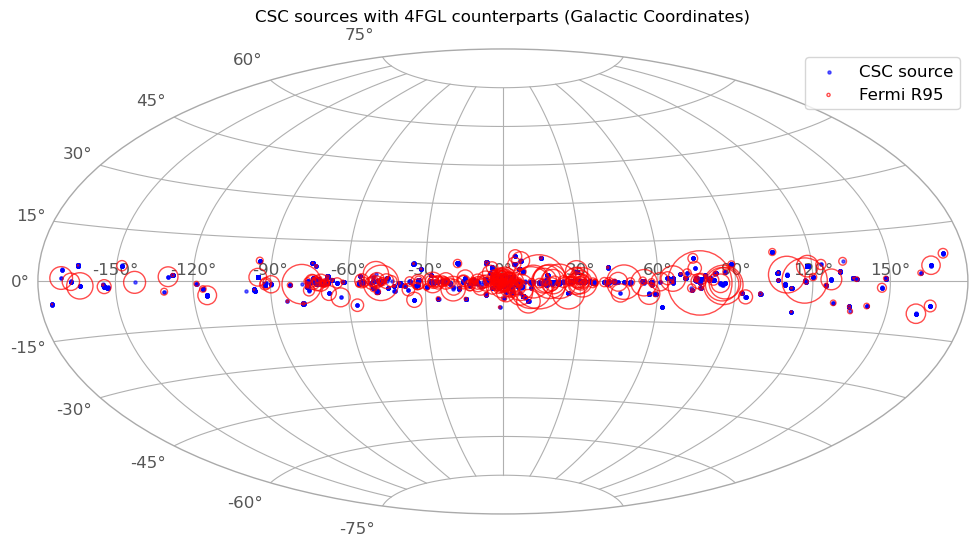

In [24]:
# Unique CSC and Fermi source rows
unique_csc = unique(matched, keys='csc_name')
unique_fermi = unique(matched, keys='fermi_name')

# CSC SkyCoords
csc_coords = SkyCoord(l=unique_csc['csc_l'], b=unique_csc['csc_b'], unit='deg', frame='galactic')
csc_lons = csc_coords.l.wrap_at(180 * u.deg).radian
csc_lats = csc_coords.b.radian

# Fermi SkyCoords
fermi_coords = SkyCoord(l=unique_fermi['fermi_l'], b=unique_fermi['fermi_b'], unit='deg', frame='galactic')
fermi_lons = fermi_coords.l.wrap_at(180 * u.deg).radian
fermi_lats = fermi_coords.b.radian

# Fermi R95 sizes
marker_scale = 100
fermi_r95_deg = unique_fermi['fermi_r95']
fermi_sizes = (fermi_r95_deg * marker_scale)**2

# Plot
plt.figure(figsize=(12, 6))
ax = plt.subplot(111, projection='aitoff')
ax.grid(True)

ax.scatter(csc_lons, csc_lats, s=5, color='blue', alpha=0.6, label='CSC source')
ax.scatter(fermi_lons, fermi_lats, s=fermi_sizes, edgecolor='red', facecolor='none', alpha=0.7)
ax.scatter(0, 0, s=5, edgecolor='red', facecolor='none', alpha=0.7, label='Fermi R95')

ax.set_title("CSC sources with 4FGL counterparts (Galactic Coordinates)", pad=20, fontsize=12)
ax.legend(loc='best')
plt.subplots_adjust(bottom=0.1, top=0.95)
plt.show()

The code below plots the matched table along the Galactic plane again, but using the Astropy WCS package so we can display only the Galactic plane.

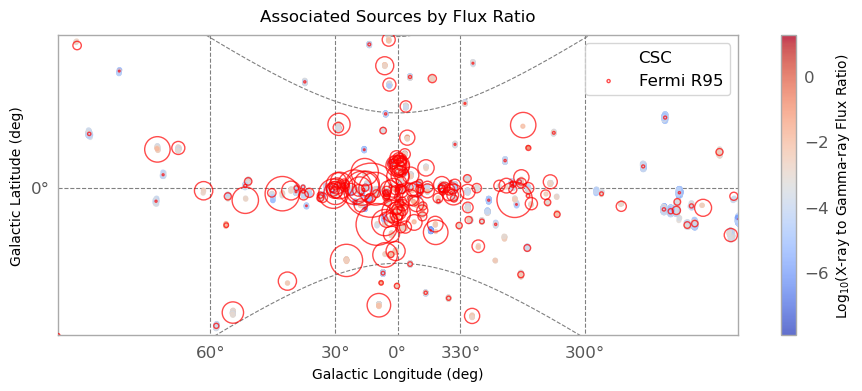

In [25]:
# Log flux ratio
flux_ratio = np.log10(matched['csc_flux'] / matched['fermi_flux'])

# Build a WCS header manually for Galactic coordinates
wcs = WCS(naxis=2)
wcs.wcs.ctype = ['GLON-TAN', 'GLAT-TAN']  # Galactic longitude/latitude
wcs.wcs.crval = [0, 0]  # Center of the plot in l and b
wcs.wcs.crpix = [900, 50]  # Reference pixel
wcs.wcs.cdelt = [-0.2, 0.2]  # Degrees per pixel
wcs.wcs.cunit = ['deg', 'deg']

# CSC SkyCoords
csc_coords = SkyCoord(l=matched['csc_l'], b=matched['csc_b'], unit='deg', frame='galactic')
csc_lons = csc_coords.l.wrap_at(180 * u.deg).deg
csc_lats = csc_coords.b.deg

# Fermi SkyCoords
fermi_coords = SkyCoord(l=unique_fermi['fermi_l'], b=unique_fermi['fermi_b'], unit='deg', frame='galactic')
fermi_lons = fermi_coords.l.wrap_at(180 * u.deg).deg
fermi_lats = fermi_coords.b.deg

# Fermi R95 sizes
marker_scale = 100
fermi_r95_deg = unique_fermi['fermi_r95']
fermi_sizes = (fermi_r95_deg * marker_scale)**2

# Convert to pixel coords
csc_x_pix, csc_y_pix = wcs.wcs_world2pix(csc_coords.l.wrap_at(180 * u.deg).deg, csc_coords.b.deg, 0)
fermi_x_pix, fermi_y_pix = wcs.wcs_world2pix(fermi_coords.l.wrap_at(180 * u.deg).deg, fermi_coords.b.deg, 0)

# Plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111, projection=wcs)

sc = ax.scatter(csc_x_pix, csc_y_pix, c=flux_ratio, cmap='coolwarm', s=8, alpha=0.8, label='CSC')

ax.scatter(fermi_x_pix, fermi_y_pix, s=fermi_sizes, edgecolor='red', facecolor='none', alpha=0.7)
ax.scatter(0, 0, s=5, edgecolor='red', facecolor='none', alpha=0.7, label='Fermi R95')

cb = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05)
cb.set_label(r'Log$_{10}$(X-ray to Gamma-ray Flux Ratio)',fontsize=10)

ax.set_xlim(0, 1800)
ax.set_ylim(0, 100)

ax.coords.grid(True, color='gray', ls='--')
ax.coords[0].set_axislabel('Galactic Longitude (deg)',fontsize=10)
ax.coords[1].set_axislabel('Galactic Latitude (deg)',fontsize=10)
ax.coords[0].set_ticks(spacing=30 * u.deg)
ax.coords[1].set_ticks(spacing=5 * u.deg)

ax.set_title("Associated Sources by Flux Ratio", pad=10,fontsize=12)
ax.legend(loc='upper right')

plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9)
plt.show()

# Step 9: Build a final table consolidating repeating entries

Get rid of repeating Fermi entries. However, we want to retain the information that several CSC sources can overlap with the same Fermi source, so we build a nested table.

In [26]:
# Step 1: Unique Fermi sources
unique_pairs = unique(matched, keys=['csc_name', 'fermi_name'])
unique_fermi_names = list(set(unique_pairs['fermi_name']))

# Step 2: Prepare row containers
rows = []

for fname in unique_fermi_names:
    # Filter for this Fermi source
    mask = unique_pairs['fermi_name'] == fname
    group = unique_pairs[mask]

    # Use first row for Fermi info
    f_row = group[0]

    # Extract CSC info as Python lists
    csc_names = list(group['csc_name'])
    csc_fluxes = list(group['csc_flux'])
    csc_lons = list(group['csc_l'])
    csc_b_lats = list(group['csc_b'])

    n_matches = len(csc_names)

    # Append row
    rows.append((
        fname,
        f_row['fermi_l'],
        f_row['fermi_b'],
        f_row['fermi_flux'],
        f_row['fermi_r95'],
        n_matches,
        csc_names,
        csc_fluxes,
        csc_lons,
        csc_b_lats
    ))

# Step 3: Build final table
grouped_display_table = Table(rows=rows, names=[
    'fermi_name', 'fermi_l', 'fermi_b', 'fermi_flux', 'fermi_r95',
    'num_csc_matches', 'csc_names', 'csc_fluxes', 'csc_glons', 'csc_glats'
])

print(len(rows))

383


There are 383 Fermi sources with CSC counterparts. Save the final table as a CSV. 

In [27]:
export_table = grouped_display_table.copy()
export_table.sort(['fermi_l', 'fermi_b'])

# Convert all list-like columns to strings
for col in export_table.colnames:
    if isinstance(export_table[col][0], (list, tuple)):
        export_table[col] = [', '.join(str(x) for x in row) for row in export_table[col]]

# Write to CSV
export_table.write("grouped_csc_fermi_pairs.csv", format="csv", overwrite=True)

# Step 10: Let's plot some of the properties of the final table

How many CSC matches per Fermi source as a function of longitude. Again we see the Galactic Center have the largest number of matches. 

/Users/jeagle/miniforge3/envs/fermi/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: UserWarning: Warning: converting a masked element to nan.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


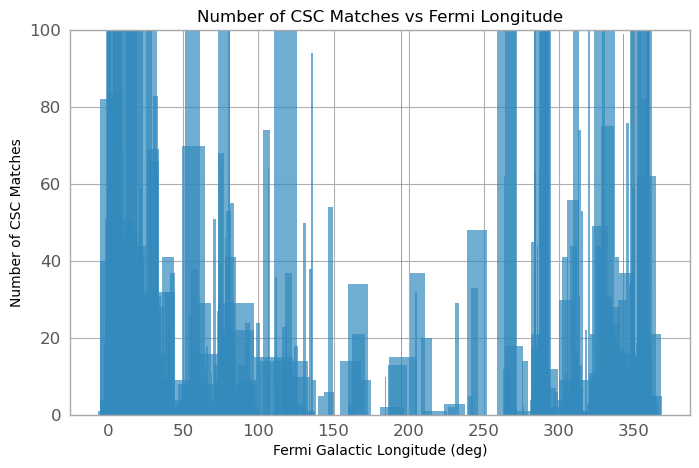

In [28]:
# Count CSC matches per Fermi source using a dict
fermi_counts = {}
for fname in matched['fermi_name']:
    fermi_counts[fname] = fermi_counts.get(fname, 0) + 1

fermi_lons = []
num_csc_matches = []

for fname, count in fermi_counts.items():
    # Find fermi longitude in unique_fermi
    idx = (unique_fermi['fermi_name'] == fname).nonzero()[0]
    if len(idx) == 0:
        continue
    lon = unique_fermi['fermi_l'][idx[0]]
    fermi_lons.append(lon)
    num_csc_matches.append(count)

plt.figure(figsize=(8,5))
plt.bar(fermi_lons, num_csc_matches, 100*unique_fermi['fermi_r95'], alpha=0.7,lw=2)
plt.xlabel('Fermi Galactic Longitude (deg)',fontsize=10)
plt.ylabel('Number of CSC Matches',fontsize=10)
plt.title('Number of CSC Matches vs Fermi Longitude', fontsize=12)
plt.ylim(0,100)
plt.grid(True)
plt.show()

What is more interesting are properties like the X- to gamma-ray flux ratios, which can help identify a specific source class or subclass. 

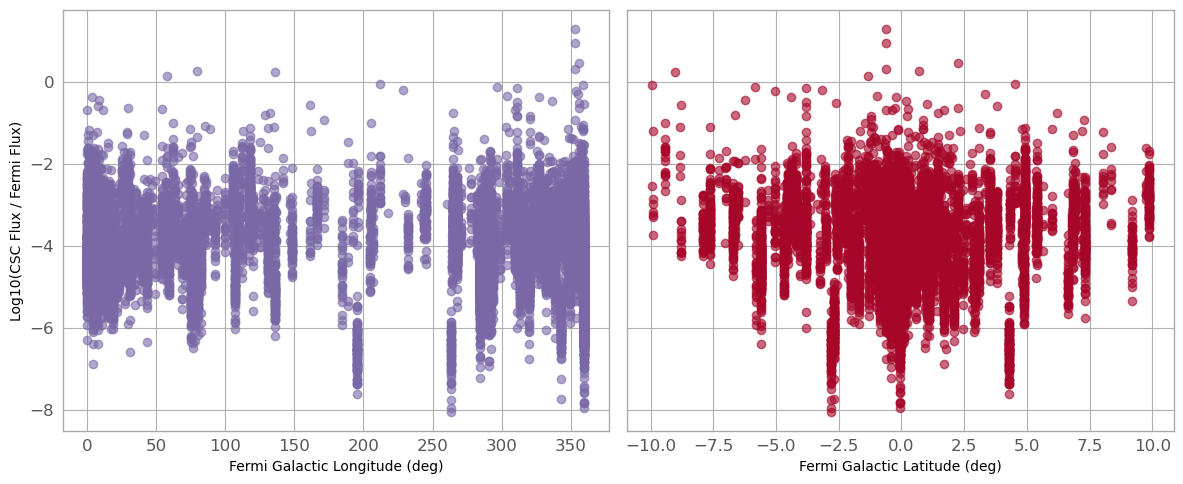

In [29]:
log_flux_ratio = np.log10(matched['csc_flux'] / matched['fermi_flux'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns

# First plot
axes[0].scatter(matched['fermi_l'], log_flux_ratio, alpha=0.6, color='C1')
axes[0].set_xlabel('Fermi Galactic Longitude (deg)', fontsize=10)
axes[0].set_ylabel('Log10(CSC Flux / Fermi Flux)', fontsize=10)
axes[0].grid(True)

# Second plot
axes[1].scatter(matched['fermi_b'], log_flux_ratio, alpha=0.6, color='C2')
axes[1].set_xlabel('Fermi Galactic Latitude (deg)', fontsize=10)
axes[1].grid(True)

plt.tight_layout()
plt.show()

Finally, we can plot the flux ratio as a function of source class (from the Fermi catalog). 

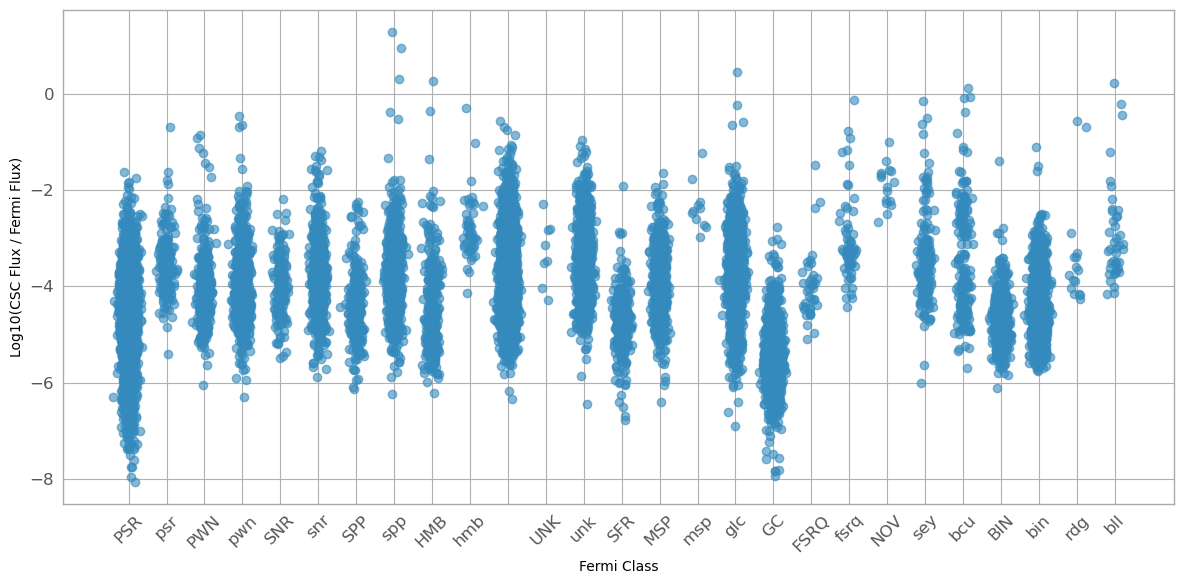

In [30]:
fermi_classes_clean = [' '.join(c.split()) for c in matched['fermi_class']]

# Define desired order explicitly - galactic to extragalactic
desired_order = ['PSR', 'psr', 'PWN', 'pwn', 'SNR', 'snr', 'SPP', 'spp','HMB', 'hmb', '', 'UNK', 'unk', 'SFR', 'MSP', 'msp',
                'glc', 'GC', 'FSRQ', 'fsrq', 'NOV', 'sey', 'bcu', 'BIN', 'bin', 'rdg', 'bll']

# Extract unique classes and map to numbers for plotting
class_to_num = {cls: i for i, cls in enumerate(desired_order)}

x_vals = np.array([class_to_num[c] for c in fermi_classes_clean])
jitter = np.random.normal(0, 0.1, size=len(x_vals))
x_jittered = x_vals + jitter

plt.figure(figsize=(12,6))
plt.scatter(x_jittered, log_flux_ratio, alpha=0.6)
plt.xticks(range(len(desired_order)), desired_order, rotation=45)
plt.xlabel('Fermi Class', fontsize=10)
plt.ylabel('Log10(CSC Flux / Fermi Flux)', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

With this cross-matched set you can do lots of things:

* Do brighter gamma-ray sources have more X-ray counterparts? Make a scatter plot of CSC matches as a function of Fermi flux.

* Assess association reliability. Here we only do a superficial cross-match using Fermi's 68% containment angle from about 10GeV. Plot the difference between Fermi and CSC coordinates as a histogram. 

* What regions of the sky show a clustering of sources? Plot a sky map where the point size is proportional to the number of CSC matches. 

* Create a new table of the subsample (maybe prioritizing one or more similar source classes) to explore further trends, etc. 